# Fantasy Rules : Decision Making rules
* Each week, players earn points based on their performance in games throughout the week;
* The aim of the game is to pick players whom you think will  earn the most points in the season;
* You are constrained to a budget of £100.0 million to choose players (better players cost more money);
* You must pick 15 players, 2 goal keepers, 5 defenders, 5 midfielders and 3 strikers;
* Only 11 players must be on the pitch (1 goalkeeper - 4 defenders - 4 midfielders - 2 strikers), and 4 on the bench (1-1-1-1);
* You can only pick up to 3 players from any given team;
* Only the 11 players selected to play can earn points each week.

In [1]:
# Imports
import requests, json
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pprint import pprint


sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 100)   

In [2]:
# base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# get data from bootstrap-static endpoint
r = requests.get(base_url+'bootstrap-static/').json()

# show the top level fields
pprint(r, indent=2, depth=1, compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 2948867}


In [3]:
# # get player data from 'elements' field
# players = r['elements']

# # show data for first player
# pprint(players[0])


In [4]:
# # create players dataframe
# players = pd.json_normalize(r['elements'])

# # show some information about first five players
# players[['id', 'web_name', 'team', 'element_type']].head()

In [5]:
# # Exctracting the teams
# # create teams dataframe
# teams = pd.json_normalize(r['teams'])

# teams.head()

In [6]:
# # Extracting the player positions

# # get position information from 'element_types' field
# positions = pd.json_normalize(r['element_types'])

# positions.head()

**Combine these three tables to get a single view of a player. We will use the merge() pandas function to join tables on their related columns. Players can be joined to teams using the players.team and teams.id columns:**

**Join the players with their teams**

In [7]:
# # join players to teams
# df = pd.merge(
#     left=players,
#     right=teams,
#     left_on='team',
#     right_on='id'
# )

# # show joined result
# df[['first_name', 'second_name', 'name']].head()

**Join the positions**

In [8]:
# # join player positions
# df = df.merge(
#     positions,
#     left_on='element_type',
#     right_on='id'
# )

# # rename columns
# df = df.rename(
#     columns={'name':'team_name', 'singular_name':'position_name'}
# )

# # show result
# df[
#     ['first_name', 'second_name', 'team_name', 'position_name']
# ].head()

**Player gameweek history**

Now that we have some basic information for players, teams and positions. Let’s get the gameweek points from the current season.

We can do this in two ways:

    * For each gameweek GID, get all player data from https://fantasy.premierleague.com/api/event/{GID}/
    * For each player PID, get gameweek history from https://fantasy.premierleague.com/api/element-summary/{PID}/

Since we already have all players in one dataframe, let’s go with option 2 and get data on a per-player basis.

The element-summary endpoint contains three fields at the top level:

    * fixtures contains upcoming fixture information
    * history contains previous gameweek player scores
    * history_past provides summary of previous season totals

In [9]:
# # get data from 'element-summary/{PID}/' endpoint for PID=4
# r = requests.get(base_url + 'element-summary/4/').json()

# # show top-level fields for player summary
# pprint(r, depth=1)

In [10]:
# # show data for first gameweek
# pprint(r['history'][0])

Function called get_gameweek_history() which takes a single argument, player_id, and returns a dataframe of their scores for all previous gameweeks:

# Player Gameweek History

In [11]:

# def get_gameweek_history(player_id):
#     '''get all gameweek info for a given player_id'''
    
#     # send GET request to
#     # https://fantasy.premierleague.com/api/element-summary/{PID}/
#     r = requests.get(
#             base_url + 'element-summary/' + str(player_id) + '/'
#     ).json()
    
#     # extract 'history' data from response into dataframe
#     df = pd.json_normalize(r['history'])
    
#     return df


# # show player #4's gameweek history
# get_gameweek_history(7)[
#     [
#         'round',
#         'total_points',
#         'minutes',
#         'goals_scored',
#         'assists'
#     ]
# ].head()

# Player Season History

In [12]:

# def get_season_history(player_id):
#     '''get all past season info for a given player_id'''
    
#     # send GET request to
#     # https://fantasy.premierleague.com/api/element-summary/{PID}/
#     r = requests.get(
#             base_url + 'element-summary/' + str(player_id) + '/'
#     ).json()
    
#     # extract 'history_past' data from response into dataframe
#     df = pd.json_normalize(r['history_past'])
    
#     return df


# # show player #1's gameweek history
# get_season_history(7)[
#     [
#         'season_name',
#         'total_points',
#         'minutes',
#         'goals_scored',
#         'assists',
#         'clean_sheets'
#     ]
# ].head(10)

# Single dataframe with player names, teams and positions

In [13]:
# # select columns of interest from players df
# players = players[
#     ['id', 'first_name', 'second_name', 'web_name', 'team',
#      'element_type']
# ]

# # join team name
# players = players.merge(
#     teams[['id', 'name']],
#     left_on='team',
#     right_on='id',
#     suffixes=['_player', None]
# ).drop(['team', 'id'], axis=1)

# # join player positions
# players = players.merge(
#     positions[['id', 'singular_name_short']],
#     left_on='element_type',
#     right_on='id'
# ).drop(['element_type', 'id'], axis=1)

# players.head()

**Pandas’ progress_apply() dataframe method to apply the get_gameweek_history() function to every row in our players dataframe.**

In [14]:
from tqdm.auto import tqdm
tqdm.pandas()

C:\Users\Bill\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Top 5 scorers of this season

In [15]:
# # get top scoring players
# points.groupby(
#     ['element', 'web_name']
# ).agg(
#     {'total_points':'sum', 'goals_scored':'sum', 'assists':'sum'}
# ).reset_index(
# ).sort_values(
#     'total_points', ascending=False
# ).head()

## Predictive Analysis for the fpl 

In [16]:
r = requests.get(base_url+'bootstrap-static/').json()
r.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [17]:
type(r)

dict

In [18]:
df = pd.json_normalize(r['elements'])
df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,NaN,None,58822,0,0,0,0,0,2,2.3,None,0,Cédric,0.0,1,False,,None,45,58822.jpg,2.3,Alves Soares,0.3,False,None,a,1,3,48,0,0,0,0,0.0,10.7,Cédric,1481,1,1,3,27,0,0,0,3,0,0,3,292,318.4,327.1,111.0,75.8,203,80,113,24,237,79,197,62,2.0,,3.0,,NaN,
1,NaN,None,80201,0,0,0,0,0,1,2.7,None,0,Bernd,0.0,2,False,,None,45,80201.jpg,2.5,Leno,0.6,False,None,a,1,3,10,0,0,0,0,0.0,2.2,Leno,360,0,0,1,9,0,0,0,0,0,10,0,69,85.0,0.0,0.0,8.5,319,23,408,37,394,27,343,24,NaN,,NaN,,NaN,
2,NaN,None,84450,0,0,0,0,0,3,2.0,None,0,Granit,0.0,3,False,,None,50,84450.jpg,2.2,Xhaka,0.4,False,None,a,1,3,60,0,0,0,0,0.0,12.0,Xhaka,2327,1,2,6,38,0,0,0,10,1,0,3,334,395.4,522.9,262.0,118.2,162,61,54,39,147,84,101,62,NaN,,NaN,,NaN,
3,NaN,None,153256,0,0,0,0,0,3,1.5,None,0,Mohamed,0.0,4,False,,None,45,153256.jpg,1.9,Elneny,1.7,False,None,a,1,3,27,0,0,0,0,0.0,6.0,Elneny,801,0,2,0,17,0,0,0,1,0,0,0,156,163.2,131.5,49.0,34.4,282,118,216,124,288,143,284,129,NaN,,NaN,,NaN,
4,NaN,None,156074,0,0,0,0,0,2,2.3,None,0,Rob,0.0,5,False,,None,45,156074.jpg,1.9,Holding,0.2,False,None,a,1,3,29,0,0,0,0,0.0,6.4,Holding,840,1,0,2,16,0,0,0,2,1,0,2,152,253.0,8.6,49.0,31.1,231,90,339,132,289,111,292,106,NaN,,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,NaN,None,216208,0,0,0,0,0,1,1.5,None,0,Matija,0.0,492,False,,None,40,216208.jpg,0.0,Šarkić,3.1,False,None,a,20,39,0,0,0,0,0,0.0,0.0,Šarkić,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,397,42,387,31,371,19,399,42,NaN,,NaN,,NaN,
521,NaN,None,222531,0,0,0,0,0,3,2.5,None,0,Morgan,0.0,493,False,,None,55,222531.jpg,0.5,Gibbs-White,0.3,False,None,a,20,39,1,0,0,0,0,0.0,0.2,Gibbs-White,7,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.7,24.0,2.1,509,218,360,167,306,149,370,162,NaN,,NaN,,NaN,
522,NaN,None,501837,0,0,0,0,0,2,1.5,None,0,Yerson,0.0,494,False,,None,40,501837.jpg,0.0,Mosquera Valdelamar,1.2,False,None,a,20,39,0,0,0,0,0,0.0,0.0,Mosquera,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,409,158,401,158,385,158,412,158,NaN,,NaN,,NaN,
523,NaN,None,19624,0,0,0,0,0,3,2.0,None,0,João Filipe Iria,0.0,503,False,,None,50,19624.jpg,2.7,Santos Moutinho,2.1,False,None,a,20,39,96,0,0,0,0,0.0,19.2,Moutinho,2970,2,1,11,40,0,0,0,4,0,0,8,511,527.8,660.9,144.0,133.2,104,39,27,19,208,110,73,46,1.0,,1.0,,NaN,


In [19]:
r['elements']

[{'chance_of_playing_next_round': None,
  'chance_of_playing_this_round': None,
  'code': 58822,
  'cost_change_event': 0,
  'cost_change_event_fall': 0,
  'cost_change_start': 0,
  'cost_change_start_fall': 0,
  'dreamteam_count': 0,
  'element_type': 2,
  'ep_next': '2.3',
  'ep_this': None,
  'event_points': 0,
  'first_name': 'Cédric',
  'form': '0.0',
  'id': 1,
  'in_dreamteam': False,
  'news': '',
  'news_added': None,
  'now_cost': 45,
  'photo': '58822.jpg',
  'points_per_game': '2.3',
  'second_name': 'Alves Soares',
  'selected_by_percent': '0.3',
  'special': False,
  'squad_number': None,
  'status': 'a',
  'team': 1,
  'team_code': 3,
  'total_points': 48,
  'transfers_in': 0,
  'transfers_in_event': 0,
  'transfers_out': 0,
  'transfers_out_event': 0,
  'value_form': '0.0',
  'value_season': '10.7',
  'web_name': 'Cédric',
  'minutes': 1481,
  'goals_scored': 1,
  'assists': 1,
  'clean_sheets': 3,
  'goals_conceded': 27,
  'own_goals': 0,
  'penalties_saved': 0,
  'pen

In [20]:
# Loading the json data and making the dataframe
data = r

player_data_json = data['elements']
pdata = pd.json_normalize(player_data_json)
to_drop = ['chance_of_playing_this_round','chance_of_playing_next_round','code','cost_change_event','cost_change_event_fall','cost_change_start','cost_change_start_fall','dreamteam_count','ep_this','event_points','form','ict_index','in_dreamteam','news','photo','special','squad_number','status','transfers_in','transfers_in_event','transfers_out','transfers_out_event','value_form','value_season']
pdata.drop(to_drop, axis=1, inplace = True)
pdata['full_name'] = pdata.first_name + " " + pdata.second_name
pdata['element_type_name'] = pdata.element_type.map({x['id']:x['singular_name_short'] for x in data['element_types']})
pdata = pdata.loc[:,['full_name','first_name','second_name', 'element_type','element_type_name','id','team', 'team_code', 'web_name',
                     'saves','penalties_saved','clean_sheets','goals_conceded',
                     'bonus', 'bps','creativity','ep_next','influence', 'threat',
                     'goals_scored','assists','minutes', 'own_goals',
                     'yellow_cards', 'red_cards','penalties_missed',
                     'selected_by_percent', 'now_cost','points_per_game','total_points']]
pdata['team'] = pdata.team.map({x['id']:x['name'] for x in data['teams']})

In [21]:
pdata

,full_name,first_name,second_name,element_type,element_type_name,id,team,team_code,web_name,saves,penalties_saved,clean_sheets,goals_conceded,bonus,bps,creativity,ep_next,influence,threat,goals_scored,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points
0,Cédric Alves Soares,Cédric,Alves Soares,2,DEF,1,Arsenal,3,Cédric,0,0,3,27,3,292,327.1,2.3,318.4,111.0,1,1,1481,0,3,0,0,0.3,45,2.3,48
1,Bernd Leno,Bernd,Leno,1,GKP,2,Arsenal,3,Leno,10,0,1,9,0,69,0.0,2.7,85.0,0.0,0,0,360,0,0,0,0,0.6,45,2.5,10
2,Granit Xhaka,Granit,Xhaka,3,MID,3,Arsenal,3,Xhaka,0,0,6,38,3,334,522.9,2.0,395.4,262.0,1,2,2327,0,10,1,0,0.4,50,2.2,60
3,Mohamed Elneny,Mohamed,Elneny,3,MID,4,Arsenal,3,Elneny,0,0,0,17,0,156,131.5,1.5,163.2,49.0,0,2,801,0,1,0,0,1.7,45,1.9,27
4,Rob Holding,Rob,Holding,2,DEF,5,Arsenal,3,Holding,0,0,2,16,2,152,8.6,2.3,253.0,49.0,1,0,840,0,2,1,0,0.2,45,1.9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Matija Šarkić,Matija,Šarkić,1,GKP,492,Wolves,39,Šarkić,0,0,0,0,0,0,0.0,1.5,0.0,0.0,0,0,0,0,0,0,0,3.1,40,0.0,0
521,Morgan Gibbs-White,Morgan,Gibbs-White,3,MID,493,Wolves,39,Gibbs-White,0,0,0,0,0,0,0.7,2.5,0.0,24.0,0,0,7,0,1,0,0,0.3,55,0.5,1
522,Yerson Mosquera Valdelamar,Yerson,Mosquera Valdelamar,2,DEF,494,Wolves,39,Mosquera,0,0,0,0,0,0,0.0,1.5,0.0,0.0,0,0,0,0,0,0,0,1.2,40,0.0,0
523,João Filipe Iria Santos Moutinho,João Filipe Iria,Santos Moutinho,3,MID,503,Wolves,39,Moutinho,0,0,11,40,8,511,660.9,2.0,527.8,144.0,2,1,2970,0,4,0,0,2.1,50,2.7,96


In [22]:
# Data exploration

pdata.corr()['total_points']
pdata.pivot_table(index='element_type_name', values='total_points', aggfunc=np.mean)
pdata.pivot_table(index='element_type_name', values='total_points', aggfunc=np.median)

,total_points
element_type_name,
DEF,39.0
FWD,55.0
GKP,5.5
MID,39.0


* clean sheets - players with more clean sheets tend to score more points.
* bps - players that earned more points in the bonus points system earned more points
* minutes - players that played more minutes tend to score more points.
* goals conceded - interestingly, the more goals players conceded the more points they earned. I think this may be driven by the minutes variable in that a player is likely to score points by actually playing and in turn are more likely to concede goals. If a player does not play, they have no chance to concede goals and they are also not able to score points.

C:\Users\Bill\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Bill\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Bill\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

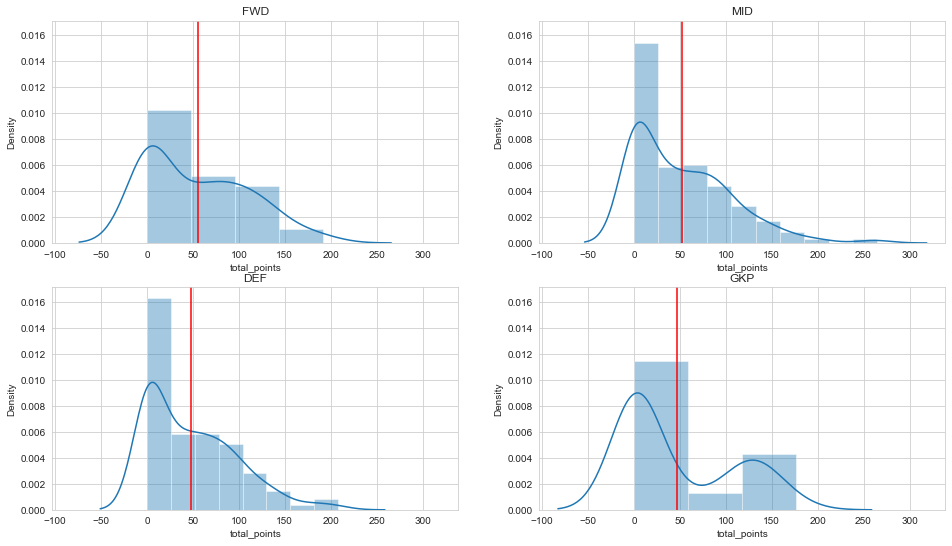

In [23]:
# Kernel Density Estimation

f = plt.figure(figsize=(16,9))
ax1 = f.add_subplot(2,2,1)
ax2 = f.add_subplot(2,2,2,sharex=ax1, sharey=ax1)
ax3 = f.add_subplot(2,2,3,sharex=ax1, sharey=ax1)
ax4 = f.add_subplot(2,2,4,sharex=ax1, sharey=ax1)
ax1.set_title('FWD')
sns.distplot(pdata[pdata.element_type_name=='FWD'].total_points, label='FWD',ax=ax1)
ax1.axvline(np.mean(pdata[pdata.element_type_name=='FWD'].total_points),color='red', label='mean')
ax2.set_title('MID')
sns.distplot(pdata[pdata.element_type_name=='MID'].total_points, label='MID',ax=ax2)
ax2.axvline(np.mean(pdata[pdata.element_type_name=='MID'].total_points),color='red', label='mean')
ax3.set_title('DEF')
sns.distplot(pdata[pdata.element_type_name=='DEF'].total_points, label='DEF',ax=ax3)
ax3.axvline(np.mean(pdata[pdata.element_type_name=='DEF'].total_points),color='red', label='mean')
ax4.set_title('GKP')
sns.distplot(pdata[pdata.element_type_name=='GKP'].total_points, label='GKP',ax=ax4)
ax4.axvline(np.mean(pdata[pdata.element_type_name=='GKP'].total_points),color='red', label='mean')
plt.show()

# Imputations

* The reason for this positive skew and leptokurtic data is due to players that had been transferred into the premier league that had no historic data and players that earned no points in the previous season. This is one of the limitations of the data. With no data about the historic performance of these players it would be difficult to judge their performance and really pick the best options for the season.
* This also highlights the naivety of the approach I have adopted in that I make assumptions that players will replicate similar performance this season as to last season. Essentially, I would like to select some of the newly transferred players as I can imagine they would be out to try and impress and potentially perform better.
* The way I decided to go about making this data usable and make the new transfers available  is imputing data. I assigned values to each of the players based on their cost. I would use the average or median of the particular stat based on the players of the same costs and same position and impute the values from there. I would then add a bit of gaussian noise multiplied by the standard deviation of the given feature to the imputed values to "simulate" random performance chances for the players with no data and to add some variance to the dataset because there are a large number of 0 scoring players (25.55%). I used a controlled gaussian by dividing by 1.5 to ensure that the variance isn't too erratic.

In [24]:
impute_cols = ['saves','penalties_saved', 'clean_sheets', 'goals_conceded', 'bonus', 'bps',
               'creativity', 'influence', 'threat', 'goals_scored','assists', 'minutes', 'own_goals',
               'yellow_cards', 'red_cards','penalties_missed','points_per_game', 'total_points']
positions = set(pdata.element_type_name)
costs = set(pdata.now_cost)
medians = {}; stds = {}

for i in positions:
    medians['{}'.format(i)] = {}
    stds['{}'.format(i)] = {}
    for c in costs:
        medians['{}'.format(i)]['{}'.format(c)] = {}
        stds['{}'.format(i)]['{}'.format(c)] = {}
        for j in impute_cols:
            if pdata[(pdata.total_points!=0)&(pdata.minutes!=0)&(pdata.element_type_name==str(i))&(pdata.now_cost==c)].shape[0] > 0:
                median = np.median(pdata[(pdata.total_points!=0)&(pdata.minutes!=0)&(pdata.element_type_name==i)&(pdata.now_cost==c)][j].astype(np.float32))
                std = np.std(pdata[(pdata.total_points!=0)&(pdata.minutes!=0)&(pdata.element_type_name==i)&(pdata.now_cost==c)][j].astype(np.float32))
                medians['{}'.format(i)]['{}'.format(c)]['{}'.format(j)] = median
                stds['{}'.format(i)]['{}'.format(c)]['{}'.format(j)] = std
            else:
                medians['{}'.format(i)]['{}'.format(c)]['{}'.format(j)] = 0
                stds['{}'.format(i)]['{}'.format(c)]['{}'.format(j)] = 0

for idx, row in pdata[(pdata.total_points==0)&(pdata.minutes==0)].iterrows():
    for col in impute_cols:
        pdata.loc[idx,col] = medians[str(row['element_type_name'])][str(row['now_cost'])][str(col)] + np.abs((np.random.randn()/1.5)*stds[str(row['element_type_name'])][str(row['now_cost'])][str(col)])

**Conclusion**
* Here I use a number of nested loops to store the medians and standard deviations specific to the position and cost of a player based on the featured columns. I make sure to use the absolute value as to avoid negative imputations and to help skew the data to a more normal distribution and remain consistent with the assumption that transferred players will be looking to perform well to impress. I softened the gaussian noise just a bit to avoid erratic data. After the imputation I then visualised the distributions and kernel density estimations and the data begins to resemble a gaussian curve, except the goalkeeper estimation which appears to remain bimodal.

# Linear Model

Modelling the problem to select the best possible 11 players that I can with as much money as I can afford to use. To model the problem in python, I will be using Pulp. Pulp is a python package that is able to model linear optimisation problems and solve them using the simplex method. I import everything from pulp and declare my Linear Programming problem and name it "Fantasy Team" and indicate that it is a maximising linear programming problem as I will be looking to maximise the number of points that I can get.

In [25]:
from pulp import *
prob = pulp.LpProblem('FantasyTeam', LpMaximize)

In [26]:
# Decision Variables 
# Variables are represented by each player
decision_variables = []
for rownum, row in pdata.iterrows():
    variable = str('x' + str(rownum))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
    decision_variables.append(variable)

print ("Total number of decision_variables: " + str(len(decision_variables)))

Total number of decision_variables: 525


# Optimisation Function

This is what I am trying to maximise as previously stated in my modelling of the problem. Each player earned a given number of points in the previous season, or they have been imputed with values based on the median + (soft gaussian noise * standard deviation) dependant on the given cost and position of that player and other players within that cost bracket in the same position. These are taken and assigned to each of the decision variables (players) and used to construct the function as shown below.

In [27]:
total_points = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            formula = row['total_points']*player
            total_points += formula

prob += total_points
print ("Optimization function: " + str(total_points))

Optimization function: 48.0*x0 + 10.0*x1 + 55.0*x10 + 4.0*x100 + 13.082988368165203*x101 + 96.33378928357169*x102 + 113.60956172306774*x103 + 136.5591991628645*x104 + 44.0*x105 + 2.0*x106 + 89.0*x107 + 88.0*x108 + 48.0*x109 + 125.0*x11 + 92.0*x110 + 61.0*x111 + 59.0*x112 + 95.0*x113 + 98.0*x114 + 141.0*x115 + 126.0*x116 + 126.0*x117 + 74.0*x118 + 13.0*x119 + 179.0*x12 + 93.0*x120 + 58.0*x121 + 58.0*x122 + 5.0*x123 + 27.0*x124 + 2.0*x125 + 5.882261066293271*x126 + 70.60094495185146*x127 + 74.91001673073873*x128 + 30.0*x129 + 75.0*x13 + 35.9112296634245*x130 + 87.0*x131 + 130.0*x132 + 128.0*x133 + 106.0*x134 + 14.0*x135 + 76.0*x136 + 19.0*x137 + 79.0*x138 + 79.0*x139 + 135.0*x14 + 52.0*x140 + 62.0*x141 + 4.0*x142 + 55.0*x143 + 77.0*x144 + 99.0*x145 + 169.0*x146 + 30.0*x147 + 49.0*x148 + 112.0*x149 + 146.0*x15 + 141.0*x150 + 130.0*x151 + 140.0*x152 + 49.0*x153 + 92.0*x154 + 81.92020047045261*x155 + 163.0*x156 + 156.69572751279296*x157 + 119.0*x158 + 17.0*x159 + 49.0*x16 + 54.0*x160 + 58.0

# Cash Constraint

Remembering that we only have £100.0million (1000 in code) to spend on the whole squad, and my tactic to pick the best 11 based on the available cash I had after buying the best of the cheapest 4 benched players. The cheapest players that I could choose from cost  a total of £17.0million (170 in code). Therefore, this left me with £83.0 million (830 in code) to pick the best performing 11 players. I set the constraint so that I could spend 830 or less on selecting the best 11 players.

In [28]:
avail_cash = 830
total_paid = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            formula = row['now_cost']*player
            total_paid += formula

prob += (total_paid <= avail_cash)

# Player Constraints

Assigning the constraints based on the number of players that I am going to choose. deciding to go with a traditional 4-4-2 formation, I had the constraints reflect this. What the constraints represent is, of all the decision variables, some are defenders, some are midfielders and some are strikers; make sure that you select 4 defenders, 4 midfielders and 2 strikers.

In [29]:
# GoalKeeper Constraint

avail_gk = 1
total_gk = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['element_type_name'] == 'GKP':
                formula = 1*player
                total_gk += formula
prob += (total_gk == avail_gk)
print(total_gk)



x1 + x101 + x104 + x106 + x117 + x137 + x14 + x151 + x158 + x168 + x181 + x182 + x185 + x191 + x216 + x222 + x23 + x232 + x238 + x273 + x275 + x294 + x30 + x302 + x311 + x323 + x326 + x339 + x34 + x341 + x343 + x363 + x370 + x372 + x393 + x400 + x416 + x420 + x425 + x445 + x446 + x448 + x450 + x451 + x476 + x482 + x500 + x506 + x520 + x72 + x77 + x82


In [30]:
# Defender Constraint

avail_def = 4
total_def = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['element_type_name'] == 'DEF':
                formula = 1*player
                total_def += formula
prob += (total_def == avail_def)
print((total_def))

x0 + x102 + x109 + x110 + x112 + x113 + x116 + x118 + x126 + x13 + x131 + x132 + x133 + x142 + x143 + x145 + x147 + x15 + x150 + x155 + x157 + x159 + x16 + x162 + x163 + x171 + x173 + x176 + x180 + x187 + x189 + x19 + x197 + x201 + x202 + x203 + x205 + x206 + x207 + x208 + x210 + x215 + x217 + x218 + x224 + x226 + x233 + x234 + x237 + x240 + x241 + x242 + x25 + x251 + x252 + x254 + x256 + x257 + x258 + x259 + x263 + x265 + x267 + x272 + x276 + x280 + x281 + x289 + x293 + x297 + x298 + x299 + x303 + x305 + x31 + x310 + x312 + x313 + x314 + x315 + x316 + x319 + x32 + x322 + x324 + x325 + x328 + x329 + x336 + x337 + x344 + x345 + x346 + x348 + x350 + x353 + x355 + x357 + x358 + x359 + x364 + x367 + x368 + x369 + x37 + x374 + x375 + x377 + x379 + x38 + x380 + x381 + x383 + x384 + x389 + x394 + x395 + x397 + x4 + x403 + x404 + x406 + x407 + x410 + x411 + x417 + x418 + x419 + x42 + x421 + x428 + x43 + x433 + x434 + x437 + x438 + x441 + x443 + x444 + x447 + x454 + x455 + x457 + x460 + x461 + 

In [31]:
# Midfilder Constraint
avail_mid = 4
total_mid = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['element_type_name'] == 'MID':
                formula = 1*player
                total_mid += formula
prob += (total_mid == avail_mid)
print((total_mid))

x100 + x103 + x105 + x108 + x11 + x111 + x115 + x119 + x12 + x120 + x121 + x122 + x123 + x124 + x125 + x128 + x130 + x134 + x135 + x136 + x138 + x139 + x140 + x144 + x146 + x148 + x152 + x153 + x156 + x160 + x164 + x165 + x166 + x167 + x169 + x17 + x170 + x175 + x177 + x178 + x179 + x18 + x184 + x188 + x190 + x192 + x193 + x194 + x195 + x196 + x198 + x199 + x2 + x20 + x204 + x209 + x21 + x211 + x212 + x213 + x214 + x22 + x220 + x221 + x223 + x225 + x229 + x230 + x231 + x235 + x236 + x24 + x243 + x244 + x245 + x247 + x248 + x249 + x250 + x253 + x26 + x260 + x261 + x262 + x266 + x268 + x269 + x270 + x271 + x277 + x278 + x28 + x282 + x283 + x284 + x285 + x286 + x287 + x288 + x290 + x291 + x295 + x296 + x3 + x300 + x304 + x306 + x307 + x308 + x317 + x318 + x320 + x321 + x327 + x33 + x330 + x331 + x332 + x333 + x340 + x347 + x349 + x35 + x351 + x352 + x354 + x356 + x36 + x360 + x362 + x365 + x366 + x376 + x382 + x385 + x386 + x387 + x388 + x390 + x391 + x392 + x396 + x399 + x40 + x401 + x40

In [32]:
# Forward Constraint
avail_fwd = 2
total_fwd = ""
for rownum, row in pdata.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['element_type_name'] == 'FWD':
                formula = 1*player
                total_fwd += formula
prob += (total_fwd == avail_fwd)
print(total_fwd)

x10 + x107 + x114 + x127 + x129 + x141 + x149 + x154 + x161 + x172 + x174 + x183 + x186 + x200 + x219 + x227 + x228 + x239 + x246 + x255 + x264 + x27 + x274 + x279 + x29 + x292 + x301 + x309 + x334 + x335 + x338 + x342 + x361 + x371 + x373 + x378 + x39 + x398 + x409 + x412 + x415 + x432 + x435 + x452 + x472 + x478 + x479 + x485 + x504 + x51 + x516 + x53 + x62 + x66 + x81 + x96 + x98


# Team Constraint
This was slightly trickier. Here I ensure that up to 3 players from any given team are selected and not any more. To achieve this, I used a hash table to store all the teams and the players (decision variables) within the team where each of their values is equal to 1 so that i am only able to pick as many players as what is available, in this case 3.

In [33]:
team_dict= {}
for team in set(pdata.team_code):
    team_dict[str(team)]=dict()
    team_dict[str(team)]['avail'] = 3
    team_dict[str(team)]['total'] = 0
    team_dict[str(team)]['fwd'] = 1
    team_dict[str(team)]['total_fwd'] = 0
    for rownum, row in pdata.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['team_code'] == team:
                    formula = 1*player
                    team_dict[str(team)]['total'] += formula
                    if row['element_type'] == 4:
                        form = 1*player
                        team_dict[str(team)]['total_fwd'] += form

    prob += (team_dict[str(team)]['total'] <= team_dict[str(team)]['avail'])
    prob += (team_dict[str(team)]['total_fwd'] <= team_dict[str(team)]['fwd'])
print(len(team_dict))
# for team in set(pdata.team_code):
#     team_dict[str(team)]=dict()
#     team_dict[str(team)]['avail'] = 3
#     team_dict[str(team)]['total'] = 0
#     team_dict[str(team)]['fwd'] = 1
#     team_dict[str(team)]['total_fwd'] = 0
#     for rownum, row in pdata.iterrows():
#         for i, player in enumerate(decision_variables):
#             if rownum == i:
#                  if row['element_type'] == 4:
#                         form = 1*player
#                         team_dict[str(team)]['total_fwd'] += team_dict[str(team)]['fwd']

#     prob += (team_dict[str(team)]['total'] <= team_dict[str(team)]['avail'
#     prob += (team_dict[str(team)]['total_fwd'] <= team_dict[str(team)]['fwd'])

20


# Solve
Now that we have put in all our decision variables, constraints and optimisation function, it's time to solve the Linear Programming Problem! This prints all the values of the decision variables with respect to the linear relationships we have highlighted in the modelling process. I have also assert that this result is the optimal result.

In [34]:
prob.writeLP('FantasyTeam.lp')
optimization_result = prob.solve()
assert optimization_result == LpStatusOptimal
print("Status:", LpStatus[prob.status])
print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
	print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  2045.4258203902762
Individual decision_variables: 
x0 = 0.0
x1 = 0.0
x10 = 0.0
x100 = 0.0
x101 = 0.0
x102 = 0.0
x103 = 0.0
x104 = 0.0
x105 = 0.0
x106 = 0.0
x107 = 0.0
x108 = 0.0
x109 = 0.0
x11 = 0.0
x110 = 0.0
x111 = 0.0
x112 = 0.0
x113 = 0.0
x114 = 0.0
x115 = 0.0
x116 = 0.0
x117 = 0.0
x118 = 0.0
x119 = 0.0
x12 = 0.0
x120 = 0.0
x121 = 0.0
x122 = 0.0
x123 = 0.0
x124 = 0.0
x125 = 0.0
x126 = 0.0
x127 = 0.0
x128 = 0.0
x129 = 0.0
x13 = 0.0
x130 = 0.0
x131 = 0.0
x132 = 0.0
x133 = 0.0
x134 = 0.0
x135 = 0.0
x136 = 0.0
x137 = 0.0
x138 = 0.0
x139 = 0.0
x14 = 0.0
x140 = 0.0
x141 = 0.0
x142 = 0.0
x143 = 0.0
x144 = 0.0
x145 = 0.0
x146 = 0.0
x147 = 0.0
x148 = 0.0
x149 = 0.0
x15 = 0.0
x150 = 0.0
x151 = 0.0
x152 = 0.0
x153 = 0.0
x154 = 0.0
x155 = 0.0
x156 = 0.0
x157 = 0.0
x158 = 0.0
x159 = 0.0
x16 = 0.0
x160 = 0.0
x161 = 0.0
x162 = 0.0
x163 = 0.0
x164 = 0.0
x165 = 0.0
x166 = 0.0
x167 = 0.0
x168 = 0.0
x169 = 0.0
x17 = 0.0
x170 = 0.0
x171 = 0.0
x172 = 0.

# Solution
Now to make sense of the results of the problem. I build a pandas dataframe of all the decisions made following the optimisation model and append it to the original dataset to see who has been selected to be in the dream team!

In [35]:
variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)

df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['variable'])
    df.loc[rownum, 'variable'] = int(value[0])

df = df.sort_values(by='variable')

#append results
for rownum, row in pdata.iterrows():
    for results_rownum, results_row in df.iterrows():
        if rownum == results_row['variable']:
            pdata.loc[rownum, 'decision'] = results_row['value']

pdata[pdata.decision==1].now_cost.sum() # Returns 830
pdata[pdata.decision==1].total_points.sum() # Returns 2010.8606251232461
pdata[pdata.decision==1].sort_values('element_type').head(11)

,full_name,first_name,second_name,element_type,element_type_name,id,team,team_code,web_name,saves,penalties_saved,clean_sheets,goals_conceded,bonus,bps,creativity,ep_next,influence,threat,goals_scored,assists,minutes,own_goals,yellow_cards,red_cards,penalties_missed,selected_by_percent,now_cost,points_per_game,total_points,decision
222,Marek Rodák,Marek,Rodák,1,GKP,213,Fulham,54,Rodák,108.394301,0.149272,5.104876,32.309048,5.556202,604.240112,11.0505,0.7,722.57,0,0.000000,0.000000,2570.610447,0.0,1.707137,0.114726,0.0,0.3,45,3.69127,157.97787,1.0
297,Andrew Robertson,Andrew,Robertson,2,DEF,284,Liverpool,14,Robertson,0.000000,0.000000,17.000000,20.000000,23.000000,770.000000,900.7,5.2,708.2,372.0,3.000000,11.000000,2537.000000,0.0,5.000000,1.000000,0.0,10.0,70,6.4,186.00000,1.0
298,Trent Alexander-Arnold,Trent,Alexander-Arnold,2,DEF,285,Liverpool,14,Alexander-Arnold,0.000000,0.000000,18.000000,22.000000,32.000000,864.000000,1449.1,5.5,865.2,515.0,2.000000,12.000000,2853.000000,0.0,2.000000,0.000000,0.0,54.6,75,6.5,208.00000,1.0
322,João Cancelo,João,Cancelo,2,DEF,306,Man City,43,Cancelo,0.000000,0.000000,19.000000,25.000000,27.000000,829.000000,786.9,4.7,796.0,851.0,1.000000,11.000000,3227.000000,0.0,7.000000,0.000000,0.0,45.0,70,5.6,201.00000,1.0
325,Aymeric Laporte,Aymeric,Laporte,2,DEF,309,Man City,43,Laporte,0.000000,0.000000,18.000000,24.000000,8.000000,714.000000,201.0,4.0,660.0,348.0,4.000000,2.000000,2830.000000,0.0,5.000000,1.000000,0.0,5.1,60,4.8,160.00000,1.0
245,James Maddison,James,Maddison,3,MID,261,Leicester,13,Maddison,0.000000,0.000000,5.000000,41.000000,24.000000,637.000000,706.2,2.7,827.4,770.0,12.000000,11.000000,2454.000000,0.0,3.000000,0.000000,0.0,6.0,80,5.2,181.00000,1.0
286,Luis Sinisterra Lucumí,Luis,Sinisterra Lucumí,3,MID,508,Leeds,2,Sinisterra,0.000000,0.000000,7.872910,44.667283,15.948520,651.058030,686.668,1.8,657.176,852.24,6.536213,4.618864,3031.342367,0.0,3.816933,0.175053,0.0,1.1,65,4.52564,173.44795,1.0
453,Son Heung-min,Son,Heung-min,3,MID,428,Spurs,6,Son,0.000000,0.000000,18.000000,30.000000,27.000000,819.000000,1051.5,4.2,1201.8,1296.0,23.000000,10.000000,3009.000000,0.0,2.000000,0.000000,0.0,26.7,120,7.4,258.00000,1.0
492,Jarrod Bowen,Jarrod,Bowen,3,MID,465,West Ham,21,Bowen,0.000000,0.000000,8.000000,46.000000,24.000000,586.000000,627.2,1.8,822.2,1223.0,12.000000,17.000000,2987.000000,0.0,6.000000,0.000000,0.0,9.1,85,5.7,206.00000,1.0
81,Ivan Toney,Ivan,Toney,4,FWD,80,Brentford,94,Toney,0.000000,0.000000,8.000000,47.000000,19.000000,502.000000,573.6,2.2,717.8,1320.0,12.000000,5.000000,2908.000000,0.0,8.000000,0.000000,0.0,5.7,70,4.2,139.00000,1.0


In [36]:
cash = pdata[pdata.decision==1].now_cost.sum() # Returns 830
cash

830